In [32]:
import numpy as np
import pandas as pd

from sklearn import preprocessing, model_selection, metrics
from sklearn import tree as Tree


import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [252]:
data = pd.read_csv("citi_field.csv")

#Keep only necessary attributes
data = data[['events','description','type','outs_when_up',
      'hc_x','hc_y','hit_distance_sc','launch_speed','launch_angle','p_throws', 'pfx_x',
        'pfx_z', 'plate_x', 'plate_z',
      'estimated_ba_using_speedangle','release_pos_z','release_pos_x']]
#Drop instances where ball wasn't hit into play
data = data[data['description']=='hit_into_play']

hits = ['single','double','triple','home_run']
#data = data[data['events'].isin(hits)]

data.loc[:,'y'] = data['events'].isin(hits)

feats = ['launch_speed','launch_angle', 'hit_distance_sc']
features = data[feats]

data = data[~features.isna().any(axis=1)]
features = data[feats]
features['bias'] = 1
features = features[['launch_speed','launch_angle']]
features['launch_angle'] = features['launch_angle']**2

X_data = np.matrix(features.to_numpy())

y=np.matrix(np.where(data['y'],1,0)).T

<ipython-input-252-d8f794234f32>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['bias'] = 1


In [253]:
x_train, x_test, y_train,y_test = model_selection.train_test_split(X_data, y)

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Task 1

In [343]:
tree = Tree.DecisionTreeClassifier()
tree = tree.fit(x_train, y_train)
yhat = tree.predict(x_test)
cm = metrics.confusion_matrix(y_test, yhat)
stats = metrics.recall_score(y_test, yhat), metrics.accuracy_score(y_test, yhat), metrics.precision_score(y_test, yhat)

In [345]:
cm, stats, metrics.confusion_matrix(tree.predict(x_train),y_train)

(array([[228,  60],
        [ 70,  55]], dtype=int64),
 (0.44, 0.6852300242130751, 0.4782608695652174),
 array([[840,  18],
        [  0, 379]], dtype=int64))

The model is performing very well on the training data and poorly on the test data. It appears we are overfitting the data.

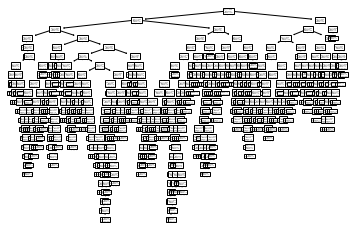

In [410]:
Tree.plot_tree(tree)
plt.show()

In [381]:
tree2 = Tree.DecisionTreeClassifier(splitter='random',class_weight='balanced')
tree2 = tree2.fit(x_train, y_train)
yhat = tree2.predict(x_test)
cm2 = metrics.confusion_matrix(y_test, yhat)
stats2 = metrics.recall_score(y_test, yhat), metrics.accuracy_score(y_test, yhat), metrics.precision_score(y_test, yhat)

In [382]:
cm2, stats2, metrics.confusion_matrix(tree2.predict(x_train),y_train)

(array([[219,  69],
        [ 56,  69]], dtype=int64),
 (0.552, 0.6973365617433414, 0.5),
 array([[821,   0],
        [ 19, 397]], dtype=int64))

To try and combat the overfitting we can add some randomness to the model. This helps slighty but the model is still strugling with the positives.

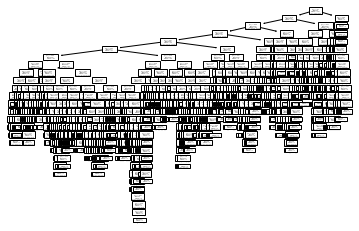

In [409]:
Tree.plot_tree(tree2)
plt.show()

In [334]:
tree3 = Tree.DecisionTreeClassifier(min_samples_leaf=3, max_depth=6, class_weight='balanced')
tree3 = tree3.fit(x_train, y_train)
yhat = tree3.predict(x_test)
cm3 = metrics.confusion_matrix(y_test, yhat)
stats3 = metrics.recall_score(y_test, yhat), metrics.accuracy_score(y_test, yhat), metrics.precision_score(y_test, yhat)

In [383]:
cm3, stats3,  metrics.confusion_matrix(tree3.predict(x_train),y_train)

(array([[197,  91],
        [ 28,  97]], dtype=int64),
 (0.776, 0.711864406779661, 0.5159574468085106),
 array([[578,  72],
        [262, 325]], dtype=int64))

Lastly, we severely limit the power of the tree. We cap the depth of the tree at 6 rows, and require each leaf to contain atleast 3 data points. I got to these values by trial and error. By limiting the number of descisions in the tree we have regularized the model and prevented it from overfitting. tree3 scores much better on recall than the prior 2 attempts. The prescision score is still not good but considering the positives only make up a small fraction of the data its not terrible.

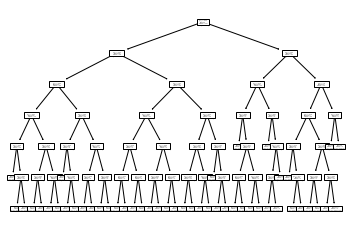

In [408]:
Tree.plot_tree(tree3)
plt.show()

## Bagging

In [349]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [422]:
cv = RepeatedStratifiedKFold(n_splits=10)
bag = BaggingClassifier(base_estimator=Tree.DecisionTreeClassifier(min_samples_leaf=3, max_depth=6, class_weight='balanced'),
                        n_estimators=10)
n_scores = cross_val_score(bag, x_train, np.array(y_train.flatten())[0], scoring='recall',cv=cv)
bag = bag.fit(x_train, np.array(y_train.flatten())[0])

In [427]:
yhat = bag.predict(x_test)
n_scores.mean(), 
stats = (metrics.recall_score(y_test,yhat), metrics.accuracy_score(y_test, yhat), metrics.precision_score(y_test,yhat))
stats, metrics.confusion_matrix(y_test,yhat),

((0.76, 0.7167070217917676, 0.521978021978022),
 array([[201,  87],
        [ 30,  95]], dtype=int64))

## Boosting

In [401]:
from sklearn.ensemble import AdaBoostClassifier

In [418]:
boost = AdaBoostClassifier(base_estimator=Tree.DecisionTreeClassifier(min_samples_leaf=3, max_depth=6, class_weight='balanced'),
                          n_estimators=10)

In [424]:
boost.fit(x_train,np.array(y_train.flatten())[0])
n_scores = cross_val_score(boost, x_train, np.array(y_train.flatten())[0], scoring='recall',cv=cv)

In [428]:
yhat = boost.predict(x_test)
n_scores.mean(), 
stats = (metrics.recall_score(y_test,yhat), metrics.accuracy_score(y_test, yhat), metrics.precision_score(y_test,yhat))
stats, metrics.confusion_matrix(y_test,yhat),

((0.616, 0.6924939467312349, 0.4935897435897436),
 array([[209,  79],
        [ 48,  77]], dtype=int64))

Both of the ensemble methods produce similar accuracy, however bagging outperforms boosting on recall and precision. 

## Task 3

The regularized descision tree yielded the best results. It performed very similarily to the baggin method and well better than the boosting algorithm. The primary metric I am using is recall. We choose this metric over pure accuracy because of the skew in the data. Most batted balls result in outs and not hits. Maximizing accuracy would likely lead to being biased towards predicting not hit because that is what most of the data are. However, we would like to best predict what results in a hit.